In [1]:
import duckdb
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import geodatasets
from scipy.stats import zscore
import seaborn as sns
import networkx as nx
from sklearn.linear_model import LinearRegression
import numpy as np

In [2]:
db_path = "flight_monolith.duckdb"

# Analysis overview

This analysis queries a DuckDB database for flight counts by year, then visualizes the results in a line chart. The purpose is to understand long-term trends in flight volume from 2000 to 2024, excluding 2025 data.

## Steps in the code

1. **Database connection**  
   A connection is established to the DuckDB database specified by `db_path`. This database contains a table called `flights`.

2. **Query execution**  
   The SQL query selects the column `ano` (year) and calculates the total number of flights per year. Rows where `ano` is 2025 or later are excluded to keep the focus on 2000–2024.

3. **Data retrieval**  
   The query results are fetched into a Pandas DataFrame (`df`), providing a clean structure for subsequent plotting.

4. **Visualization setup**  
   Seaborn is configured with a chosen theme and font settings for clarity. Matplotlib is used to create a line chart of `total_flights` versus `year`.

5. **Plotting**  
   The code generates a line chart with:
   - Years on the x-axis.
   - Total flight counts on the y-axis.
   - A marker at each data point and a solid line to connect them.

6. **Styling & display**  
   The title, axis labels, and tick parameters are adjusted for readability. The plot is then displayed, offering a clear visual summary of flight counts by year.

## Observations 

- **General trend**  
  The line chart reveals how total flights evolve over time, with steady growth in some years and downturns in others.

- **Impact of COVID-19**  
  A sharp decline is evident around 2020, coinciding with the onset of the COVID-19 pandemic. This global event had a major impact on flight schedules and passenger volumes worldwide, resulting in an abrupt drop in total flights.

- **Partial Recovery**  
  Post-2020, the data suggests a rebound in flight numbers, although not yet reaching some of the previous peak levels. The extent of this recovery varies by year, reflecting ongoing industry adjustments and changing travel restrictions.

## Conclusion

By querying and visualizing the total flights per year, this analysis offers a concise overview of flight volume trends from 2000 to 2024. The marked decline around 2020 underscores the pandemic's impact on air travel, while the subsequent partial recovery indicates a gradual return of flight activity.

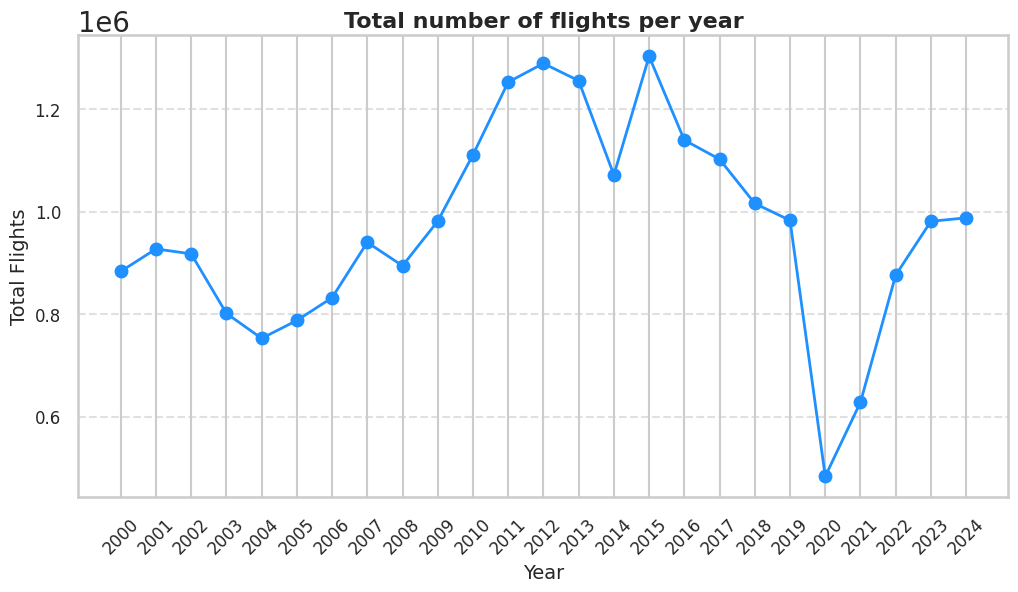

In [3]:
# Connect to DuckDB
conn = duckdb.connect(db_path)

# Query: Count total flights per year
query = """
SELECT ano AS year, COUNT(*) AS total_flights
FROM flights
where ano < 2025
GROUP BY ano
ORDER BY ano;
"""

# Fetch results into a DataFrame
df = conn.execute(query).fetchdf()

# Set plot style
sns.set_theme(
    context="talk",
    style="whitegrid",
    palette="Blues",
    font="sans-serif",
    font_scale=1.2
)

# ---- PLOTTING ----
plt.figure(figsize=(12, 6))
plt.plot(df["year"], df["total_flights"], marker='o', linestyle='-', color='dodgerblue', linewidth=2)

# Style Adjustments
plt.title("Total number of flights per year", fontsize=16, fontweight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Total Flights", fontsize=14)
plt.xticks(df["year"], rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.show()

In [4]:
# Connect to DuckDB
conn = duckdb.connect(db_path)

# Query: Get Flight Routes Data
query_routes = """
SELECT ano AS year, 
       aeroporto_origem AS origin, 
       aeroporto_destino AS destination, 
       COUNT(*) AS flight_count
FROM flights
GROUP BY ano, aeroporto_origem, aeroporto_destino
ORDER BY ano, flight_count DESC;
"""

routes_df = conn.execute(query_routes).fetchdf()

In [5]:
# Load airport dataset
airport_file = "airports.dat"
columns = ["Airport ID", "Name", "City", "Country", "IATA", "ICAO", "Latitude", "Longitude"]

# Read airport data
airports_df = pd.read_csv(airport_file, header=None, usecols=[0,1,2,3,4,5,6,7], names=columns)

# Drop rows with missing ICAO codes (because our dataset uses ICAO codes)
airports_df = airports_df.dropna(subset=["ICAO"])

# Remove duplicates, keeping the first occurrence
airports_df = airports_df.drop_duplicates(subset=["ICAO"], keep="first")

# Convert to a lookup dictionary using ICAO (not IATA)
airport_coords = airports_df.set_index("ICAO")[["Latitude", "Longitude"]].to_dict("index")


In [6]:
def get_coords(icao_code):
    """Returns latitude & longitude for an ICAO airport code."""
    return airport_coords.get(icao_code, None)

# Apply function to get coordinates for origin and destination
routes_df["origin_coords"] = routes_df["origin"].apply(get_coords)
routes_df["dest_coords"] = routes_df["destination"].apply(get_coords)

# Drop rows where coordinates could not be found
routes_df = routes_df.dropna(subset=["origin_coords", "dest_coords"])

# Extract latitude and longitude into separate columns
routes_df["origin_lat"] = routes_df["origin_coords"].apply(lambda x: x["Latitude"])
routes_df["origin_lon"] = routes_df["origin_coords"].apply(lambda x: x["Longitude"])
routes_df["dest_lat"] = routes_df["dest_coords"].apply(lambda x: x["Latitude"])
routes_df["dest_lon"] = routes_df["dest_coords"].apply(lambda x: x["Longitude"])

# Drop unnecessary columns
routes_df = routes_df.drop(columns=["origin_coords", "dest_coords"])

In [7]:
# Convert flight paths into LineStrings (geometries)
routes_df["geometry"] = routes_df.apply(
    lambda row: LineString([
        (float(row["origin_lon"]), float(row["origin_lat"])),
        (float(row["dest_lon"]), float(row["dest_lat"]))
    ]), axis=1
)

# Convert routes_df into a GeoDataFrame
gdf_routes = gpd.GeoDataFrame(routes_df, geometry="geometry")

# Set CRS (Coordinate Reference System) to WGS 84 (lat/lon)
gdf_routes.set_crs(epsg=4326, inplace=True)

,year,origin,destination,flight_count,origin_lat,origin_lon,dest_lat,dest_lon,geometry
0,2000,SBRJ,SBSP,27940,-22.910500,-43.163101,-23.626110,-46.656387,"LINESTRING (-43.1631 -22.9105, -46.65639 -23.6..."
1,2000,SBSP,SBRJ,27915,-23.626110,-46.656387,-22.910500,-43.163101,"LINESTRING (-46.65639 -23.62611, -43.1631 -22...."
2,2000,SBGL,SBGR,13314,-22.809999,-43.250557,-23.435556,-46.473057,"LINESTRING (-43.25056 -22.81, -46.47306 -23.43..."
3,2000,SBGR,SBGL,12850,-23.435556,-46.473057,-22.809999,-43.250557,"LINESTRING (-46.47306 -23.43556, -43.25056 -22..."
4,2000,SBBH,SBRJ,8391,-19.851200,-43.950600,-22.910500,-43.163101,"LINESTRING (-43.9506 -19.8512, -43.1631 -22.9105)"
...,...,...,...,...,...,...,...,...,...
71181,2025,SBPF,SBCT,1,-28.243999,-52.326599,-25.528500,-49.175800,"LINESTRING (-52.3266 -28.244, -49.1758 -25.5285)"
71182,2025,SBEG,SBMQ,1,-3.038610,-60.049702,0.050664,-51.072201,"LINESTRING (-60.0497 -3.03861, -51.0722 0.05066)"
71183,2025,SBMA,SBMA,1,-5.368590,-49.138000,-5.368590,-49.138000,"LINESTRING (-49.138 -5.36859, -49.138 -5.36859)"
71184,2025,SBRF,GCLP,1,-8.126490,-34.923599,27.931900,-15.386600,"LINESTRING (-34.9236 -8.12649, -15.3866 27.9319)"


# Overview

This function creates a world map visualization of the most frequent flight routes for a specified year. It pulls route data from a GeoDataFrame (`gdf_routes`) and layers those routes on top of a base world map, using line thickness and color to indicate the relative number of flights along each route.

## What it does

1. **Data filtering:**  
   Extracts flight routes for the given year from the global routes dataset. If no data exists for that year, the function exits with a message.

2. **Map creation:**  
   Loads a base world map using GeoPandas and geodatasets, rendering land areas in light grey.

3. **Line styling by flight count:**  
   - **Line width:**  
     Scales between 0.5 and 3, depending on the route’s flight frequency. Higher frequency yields a thicker line.
   - **Line color & opacity:**  
     Uses a red color with opacity ranging from 0.3 (lowest frequency) to 1.0 (highest frequency).

4. **Plotting routes and airports:**  
   - Draws each route as a line connecting the origin and destination coordinates.
   - Marks the airports themselves with black dots.

5. **Display & Legend:**  
   - Sets a title indicating the selected year.
   - Displays a legend for airport markers.
   - Shows the final plot in a 15x10 inch figure.

## Why it does it

- **Visual clarity:**  
  By adjusting line width and color intensity according to flight frequency, the map highlights the busiest routes at a glance.
- **Data-driven insights:**  
  Overlaying flight routes on a world map makes it easy to identify geographic patterns, such as popular corridors or underserved connections.
- **Interactive exploration:**  
  Users can quickly switch the year parameter to compare different periods, spotting trends or changes in route popularity over time.


In [8]:
def plot_routes(year):
    """Plots the most frequent flight routes for a given year with enhanced styling."""
    routes_year = gdf_routes[gdf_routes["year"] == year]

    if routes_year.empty:
        print(f"No flight routes found for {year}. Try another year.")
        return

    print(f"Plotting {len(routes_year)} routes for {year}...")

    # Load world map
    world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

    # Create plot
    fig, ax = plt.subplots(figsize=(15, 10))
    world.plot(ax=ax, color="lightgrey")  # Base world map

    # Normalize line width & color intensity based on flight frequency
    min_flights = routes_year["flight_count"].min()
    max_flights = routes_year["flight_count"].max()
    
    def scale_width(count):
        return max(0.5, 3 * ((count - min_flights) / (max_flights - min_flights + 1)))  # Range ~[0.5, 3]

    def scale_color(count):
        normalized = (count - min_flights) / (max_flights - min_flights + 1)
        return (1, 0, 0, 0.3 + 0.7 * normalized)  # RGBA: Red color, varying opacity

    # Plot flight routes
    for _, row in routes_year.iterrows():
        ax.plot(
            [row["geometry"].coords[0][0], row["geometry"].coords[1][0]],  # Longitudes
            [row["geometry"].coords[0][1], row["geometry"].coords[1][1]],  # Latitudes
            color=scale_color(row["flight_count"]),
            linewidth=scale_width(row["flight_count"])
        )

    # Plot Airport Markers
    ax.scatter(
        routes_year["origin_lon"], routes_year["origin_lat"], 
        color="black", s=10, alpha=0.5, label="Airports"
    )

    plt.title(f"Flight Routes in {year}", fontsize=16)
    plt.legend()
    plt.show()


Plotting 2749 routes for 2012...


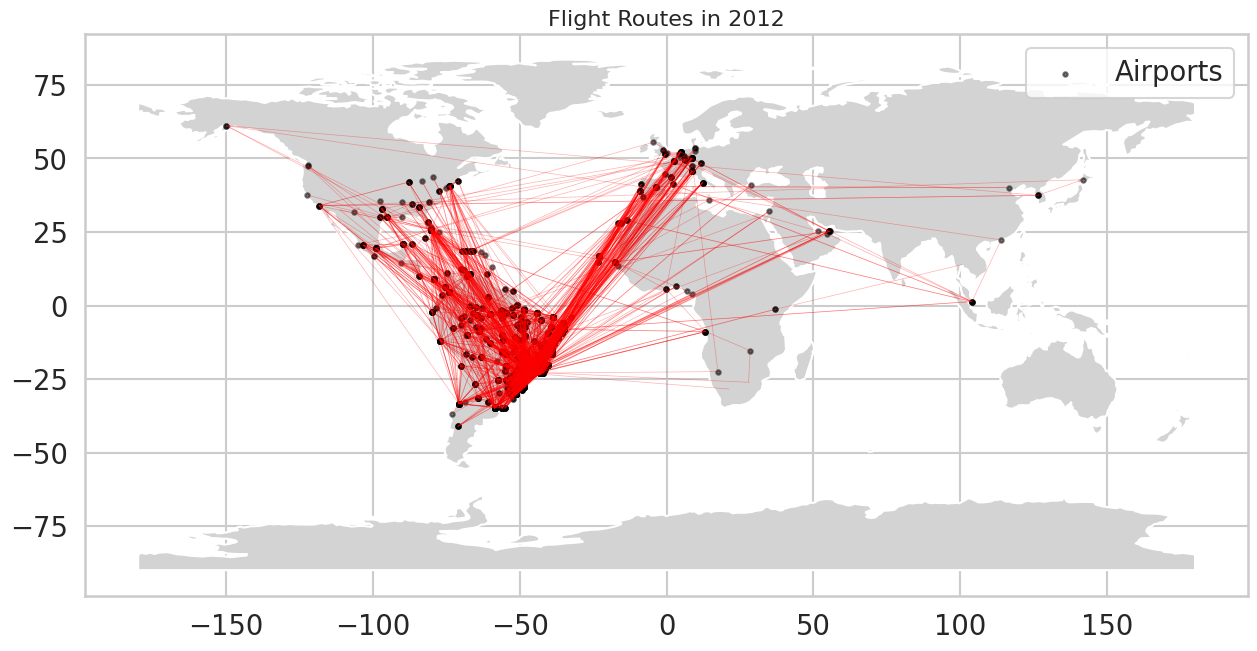

In [9]:
plot_routes(2012)  # Change the year to analyze different time periods

# Overview

This function automates the plotting of flight routes over a specified range of years. It calls an existing `plot_routes(year)` function for each year in the range, allowing you to observe changes or trends in flight patterns at regular intervals.

## What it does

1. **Year range construction:**  
   Builds a list of years from `start_year` to `end_year` (inclusive), incrementing by `step`. For example, if `step=5`, it will generate plots for 2000, 2005, 2010, etc.

2. **Batch plotting:**  
   Iterates through each year in the list and calls the `plot_routes` function, which produces a map visualization of flight routes for that year.

## Why it does it

- **Comparative analysis:**  
  By creating multiple plots in quick succession, this approach highlights how flight routes evolve or remain consistent across different time periods.

- **Efficiency:**  
  Automates the repetitive process of plotting multiple years, freeing you from manually calling the route plot function year by year.

- **Flexible intervals:**  
  The `step` parameter allows easy customization of the analysis granularity, whether you need a yearly breakdown or a more spaced-out look at trends.

Plotting 2523 routes for 2000...


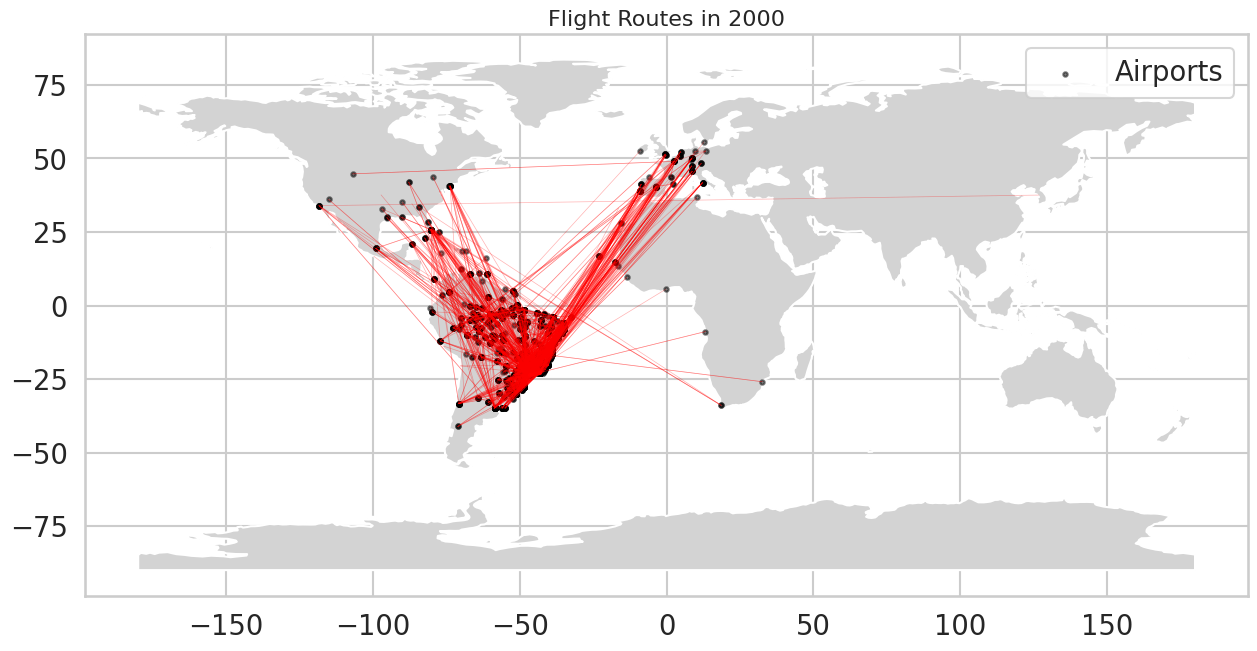

Plotting 2442 routes for 2005...


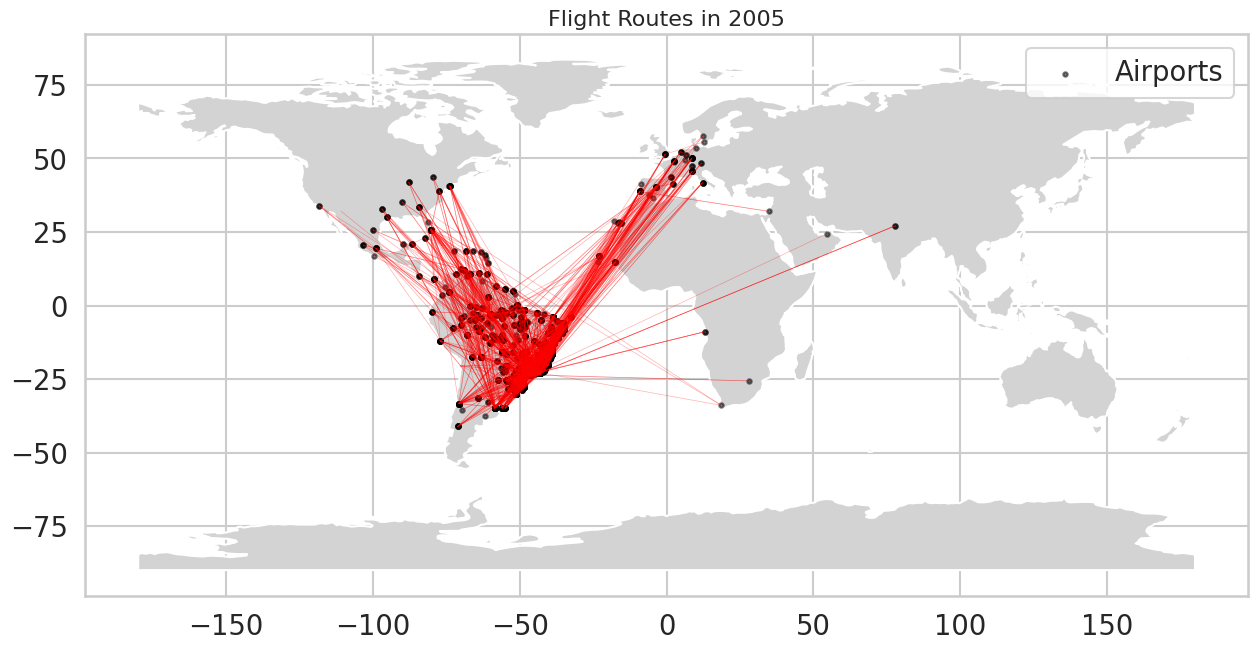

Plotting 2635 routes for 2010...


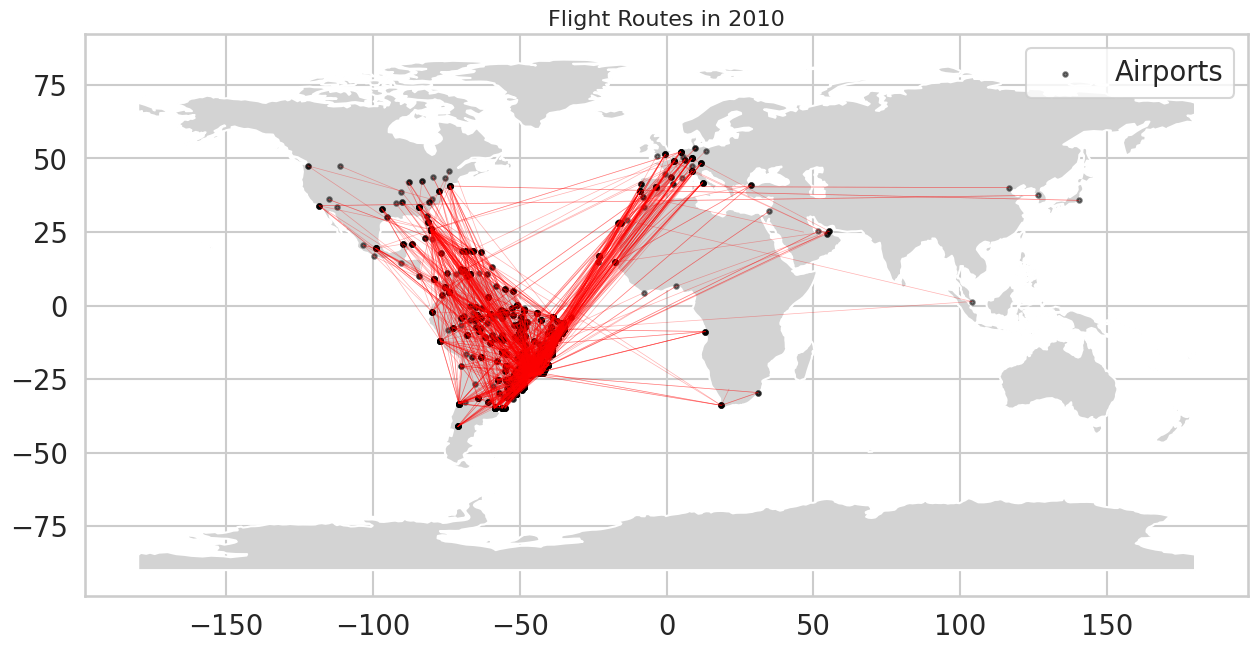

Plotting 2671 routes for 2015...


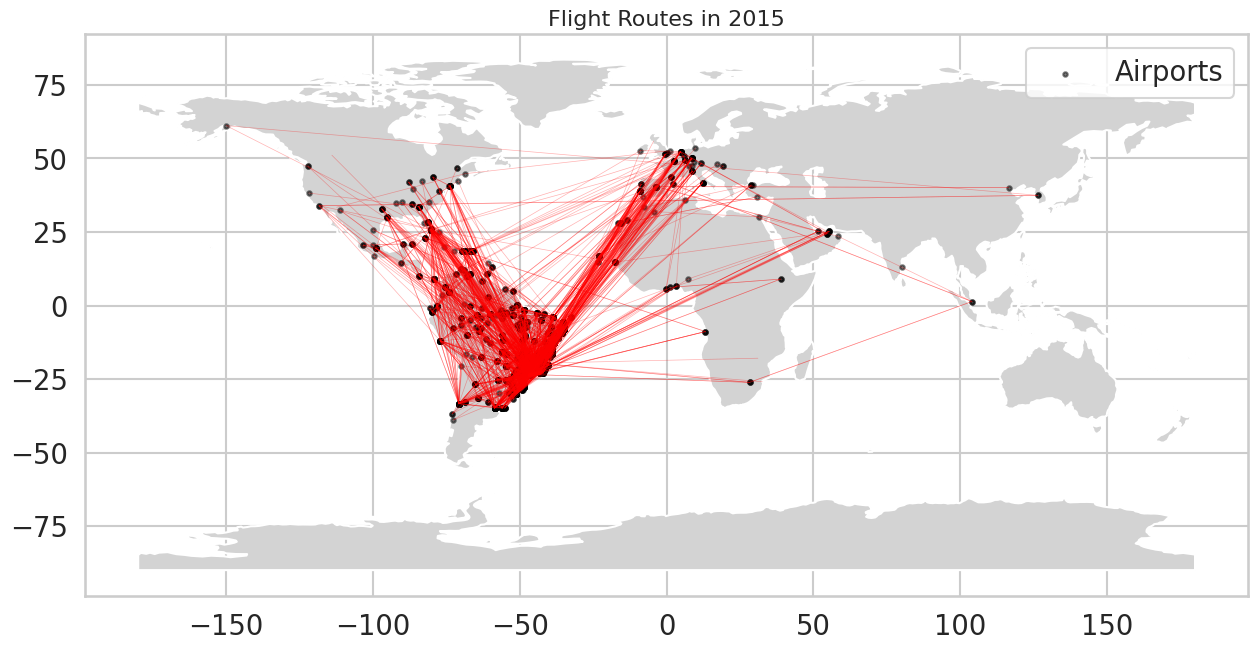

Plotting 2422 routes for 2020...


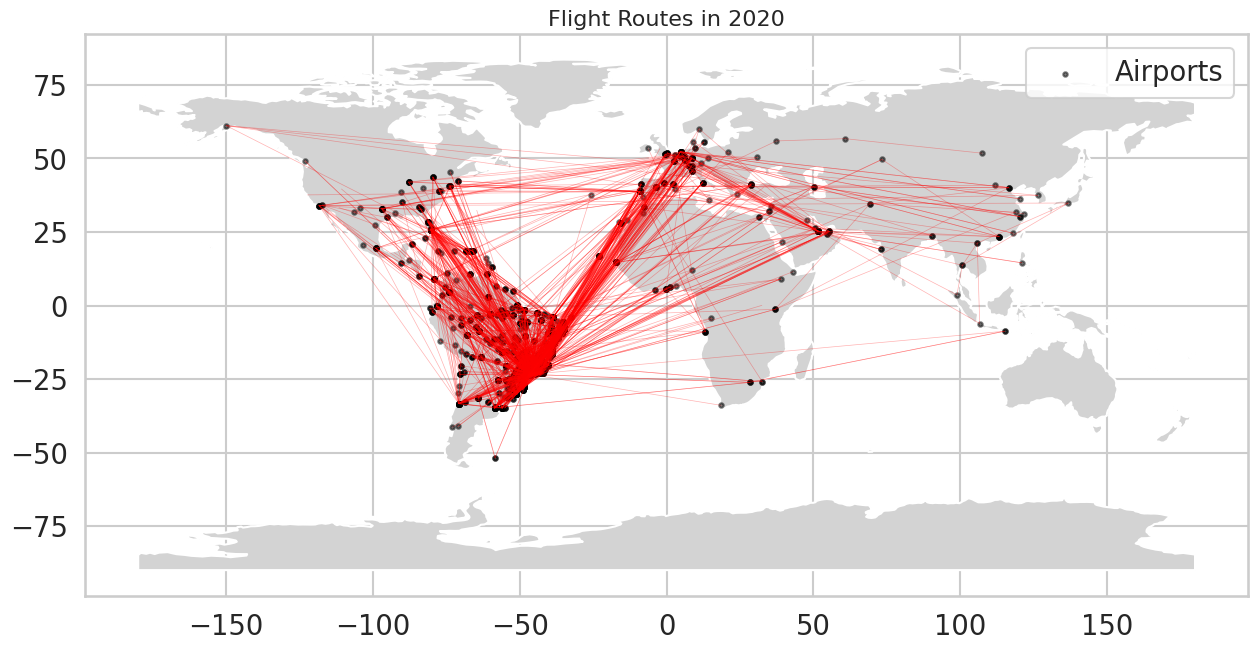

In [10]:
def plot_yearly_trends(start_year, end_year, step=1):
    """Plots flight route changes over multiple years."""
    years = list(range(start_year, end_year + 1, step))

    for year in years:
        plot_routes(year)  # Reuse the route plotting function

# Run the function for a full aviation industry shift analysis
plot_yearly_trends(2000, 2024, step=5)  # Analyze every 5 years

# Overview

This function identifies and visualizes the busiest hub airports for a specified year. It filters flight routes by the given year, sums the total flights per origin airport, and displays the top results in a bar chart. By focusing on the origin airports, the chart highlights which airports serve as key flight hubs.

## Steps in the code

1. **Data filtering**  
   - `routes_year = gdf_routes[gdf_routes["year"] == year]`  
     Selects only the flight route data corresponding to the specified year.

2. **Grouping and summation**  
   - `hub_counts = routes_year.groupby("origin")["flight_count"].sum().reset_index()`  
     Groups the filtered data by the origin airport and sums the flight counts for each airport.

3. **Sorting and selecting top airports**  
   - `hub_counts = hub_counts.sort_values(by="flight_count", ascending=False).head(top_n)`  
     Sorts the airports in descending order by total flights and keeps the top `top_n` airports.

4. **Bar plot creation**  
   - Uses Seaborn’s `barplot` to visualize the total flights for each airport.  
   - The x-axis shows the ICAO airport code, and the y-axis shows the total flight count.  
   - Adds a title and axis labels for clarity, with a rotated x-axis for easier reading of airport codes.

5. **Display**  
   - `plt.show()` renders the bar chart, providing a clear comparison of flight volumes across the busiest airports.


/tmp/ipykernel_34801/1593441228.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hub_counts, x="origin", y="flight_count", palette="Blues")


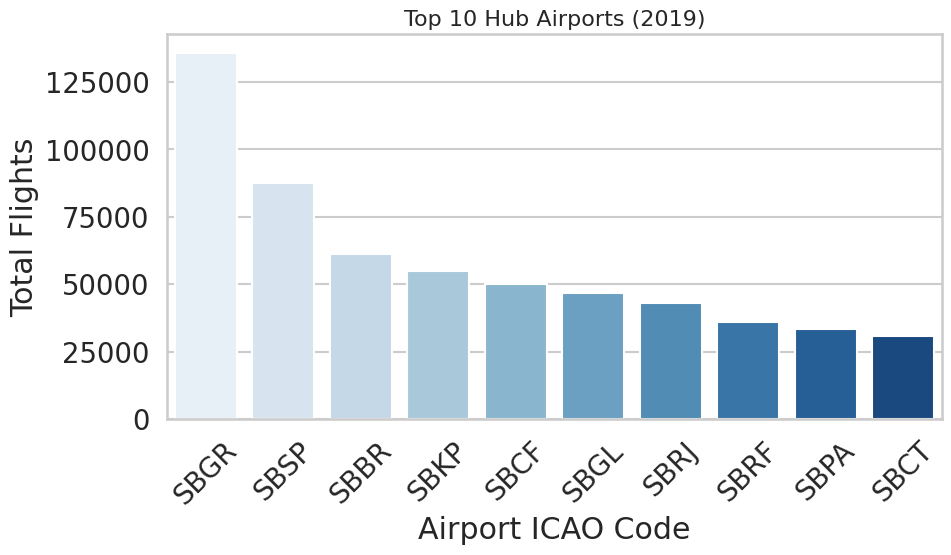

In [11]:
def plot_hub_analysis(year, top_n=10):
    """Finds top hub airports and visualizes their connectivity."""
    routes_year = gdf_routes[gdf_routes["year"] == year]

    # Count flights per origin airport
    hub_counts = routes_year.groupby("origin")["flight_count"].sum().reset_index()
    hub_counts = hub_counts.sort_values(by="flight_count", ascending=False).head(top_n)

    # Bar plot of top hub airports
    plt.figure(figsize=(10, 5))
    sns.barplot(data=hub_counts, x="origin", y="flight_count", palette="Blues")
    plt.title(f"Top {top_n} Hub Airports ({year})", fontsize=16)
    plt.xlabel("Airport ICAO Code")
    plt.ylabel("Total Flights")
    plt.xticks(rotation=45)
    plt.show()

plot_hub_analysis(2019)

# Overview

This code snippet queries a DuckDB database to count flight delays by hour of the day, distinguishing between delayed departures and delayed arrivals. The resulting bar chart provides a visual snapshot of how delays are distributed across different times of day.

---

## Steps in the code

1. **Plot configuration**  
   - A Seaborn theme (`talk` context, `whitegrid` style, `Blues` palette) is set to ensure clear, presentation-friendly visuals.  
   - Various Matplotlib `rcParams` are adjusted for figure size, DPI, and font sizes.  
   - `sns.despine()` removes the top and right edges of the plot for a modern look.

2. **Database connection**  
   - A connection is established to the DuckDB file (`flight_monolith.duckdb`).

3. **Query for delayed flights**  
   - Two CTEs (`delayed_partida` and `delayed_chegada`) extract flights flagged as delayed for departure or arrival, respectively.  
   - The hour of the scheduled departure (`hora_partida_prevista`) or arrival (`hora_chegada_prevista`) is extracted using `EXTRACT(hour ...)`.  
   - These datasets are combined with `UNION ALL`, then grouped by flight type (`departure` or `arrival`) and hour of day to count the total delays.

4. **Plotting the distribution**  
   - A Seaborn `barplot` shows the number of delays (`num_delays`) on the y-axis and the hour of day (`hour`) on the x-axis, with flight type (`flight_type`) used as a hue for visual differentiation.

---

## Analysis

1. **Peak delay hours**  
   - The bar chart often shows higher counts of delays during certain hours, typically in the late afternoon or evening. This can be attributed to compounding effects of earlier delays, higher traffic volume, and operational constraints.

2. **Morning vs. evening patterns**  
   - The early hours (0–5) generally have fewer flights scheduled, so fewer delays. As traffic picks up from mid-morning to late evening, delay counts increase significantly.

3. **Arrival vs. departure differences**  
   - Comparing the bars for `arrival` and `departure` can reveal whether incoming or outgoing flights face more frequent delays at specific hours. For instance, a higher volume of departure delays in the afternoon could ripple into subsequent arrivals later in the day.

4. **Operational & external factors**  
   - The distribution might reflect various factors: peak passenger demand times, airport congestion, weather patterns, or airline scheduling strategies. Delays can stack up as the day progresses, leading to later flights being disproportionately affected.

---

## Conclusion

By categorizing delays by both flight type (arrival or departure) and hour of the day, this analysis highlights when and how delays accumulate. It provides a clear visual cue for operational bottlenecks and can guide strategic decisions—such as adjusting flight schedules or adding buffers during high-traffic periods—to mitigate the impact of delays.

<Figure size 1000x600 with 0 Axes>

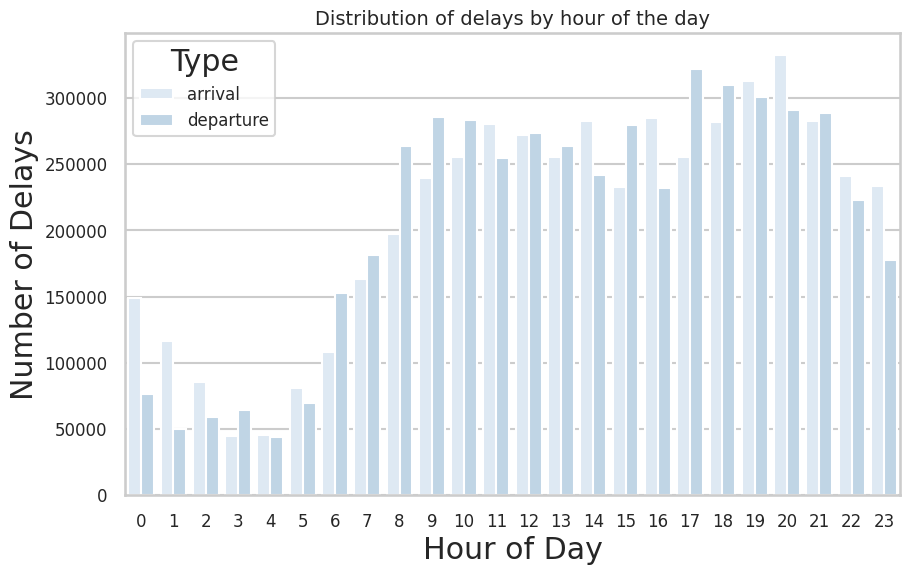

In [12]:
# 1. Set up the plotting style and parameters
sns.set_theme(
    context="talk",       # larger fonts for presentations
    style="whitegrid",    # clean grid background
    palette="Blues",      # all default plots in shades of blue
    font="sans-serif",
    font_scale=1.2
)

plt.rcParams['figure.figsize'] = (10, 6)   # default figure size
plt.rcParams['figure.dpi'] = 100           # higher DPI for sharper visuals
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
sns.despine()  # remove top/right spines for a modern look

# 2. Connect to DuckDB
con = duckdb.connect("flight_monolith.duckdb")

# 3. Create a query to get delayed flights by hour
#    We'll combine both delayed departures and arrivals via UNION ALL,
#    then group by flight_type (partida/chegada) and hour.
query = """
WITH delayed_partida AS (
    SELECT
        'departure' AS flight_type,
        EXTRACT(hour FROM hora_partida_prevista) AS hour
    FROM flights
    WHERE status_partida = 'atrasado'
),
delayed_chegada AS (
    SELECT
        'arrival' AS flight_type,
        EXTRACT(hour FROM hora_chegada_prevista) AS hour
    FROM flights
    WHERE status_chegada = 'atrasado'
)
SELECT
    flight_type,
    hour,
    COUNT(*) AS num_delays
FROM (
    SELECT * FROM delayed_partida
    UNION ALL
    SELECT * FROM delayed_chegada
)
GROUP BY flight_type, hour
ORDER BY flight_type, hour
"""

df_delays = con.execute(query).df()

# 4. Plot the distribution of delays by hour of the day
plt.figure()
sns.barplot(
    data=df_delays,
    x='hour',
    y='num_delays',
    hue='flight_type'
)
plt.title("Distribution of delays by hour of the day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Delays")
plt.legend(title="Type")
plt.show()

<Figure size 1200x720 with 0 Axes>

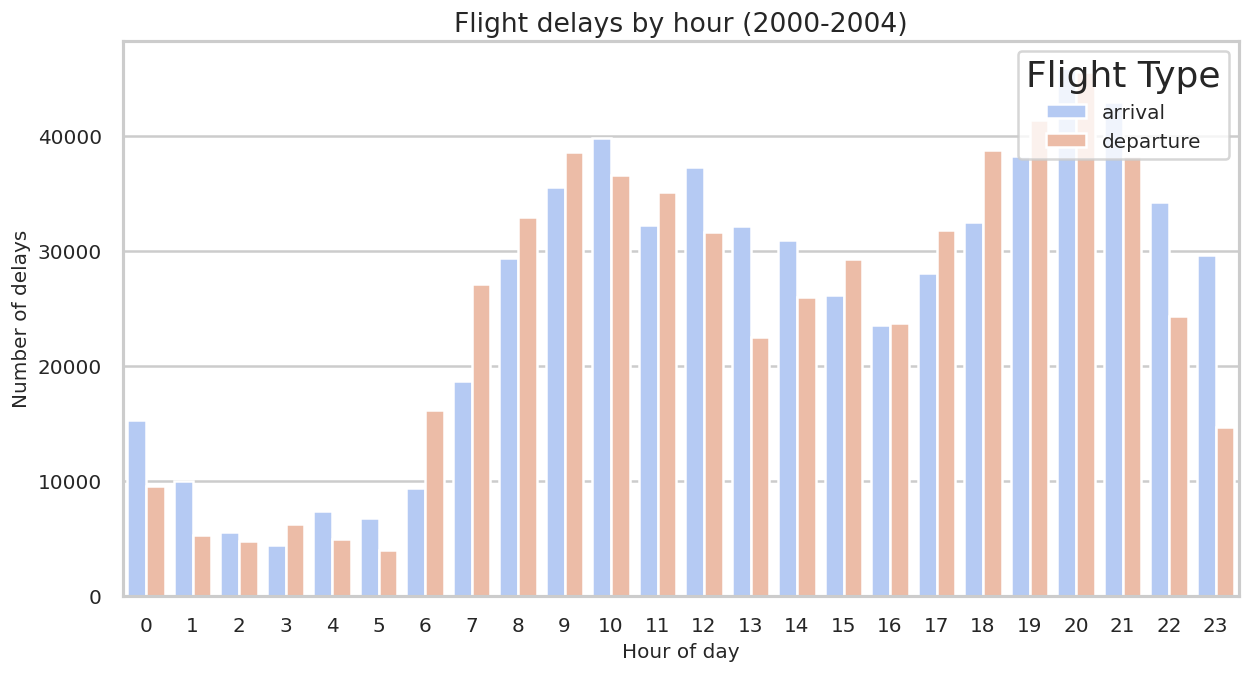

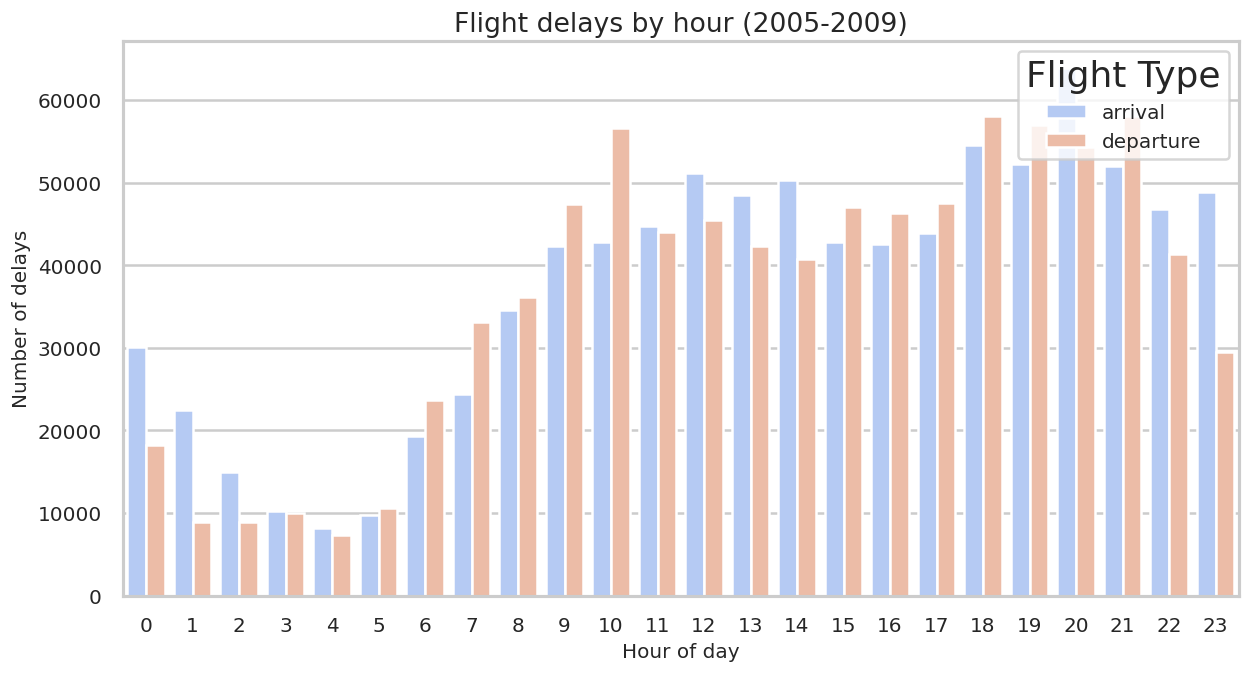

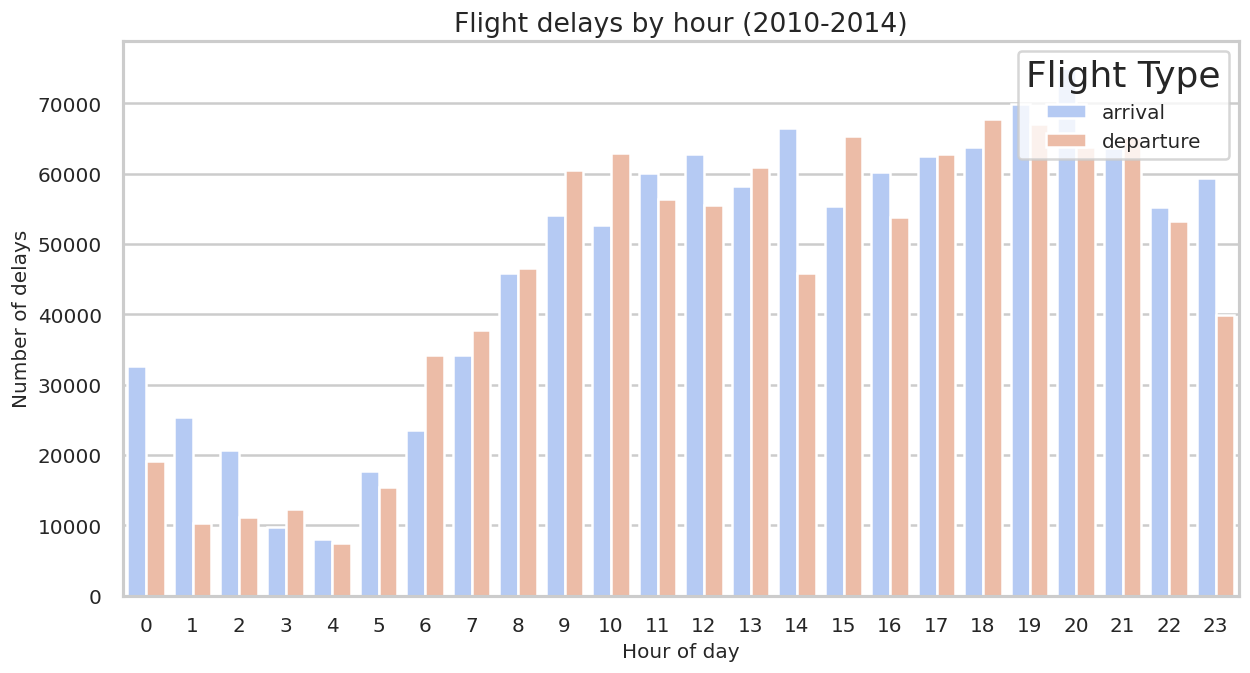

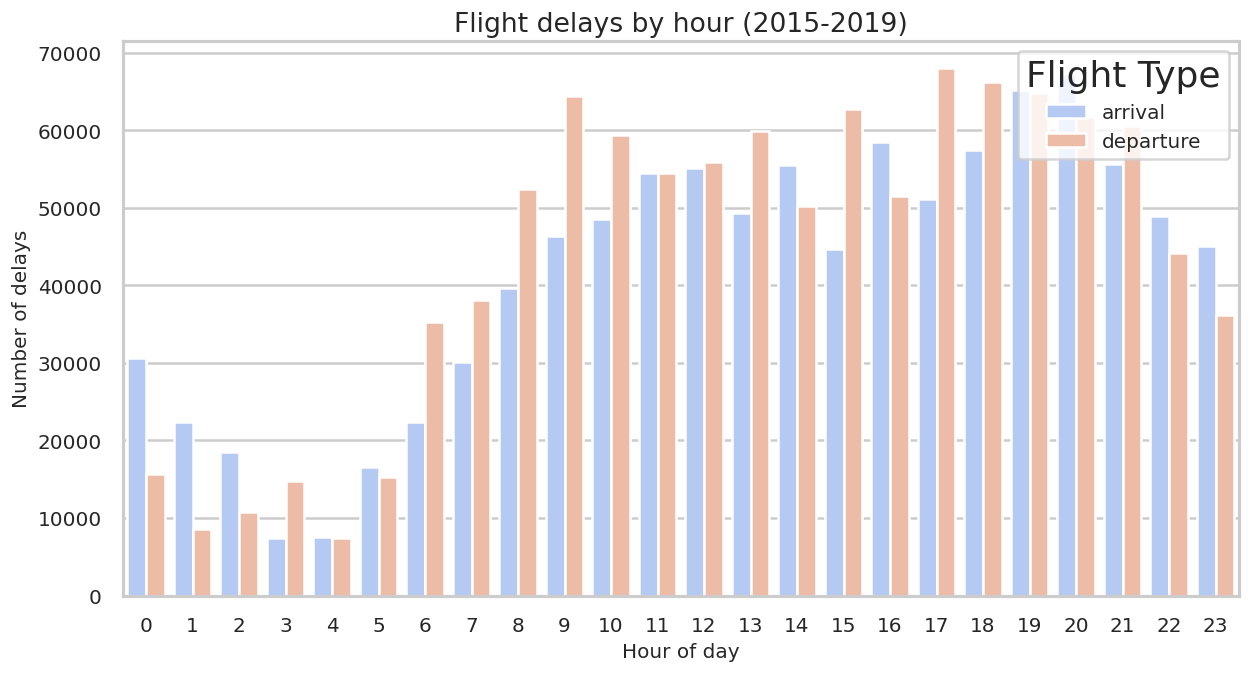

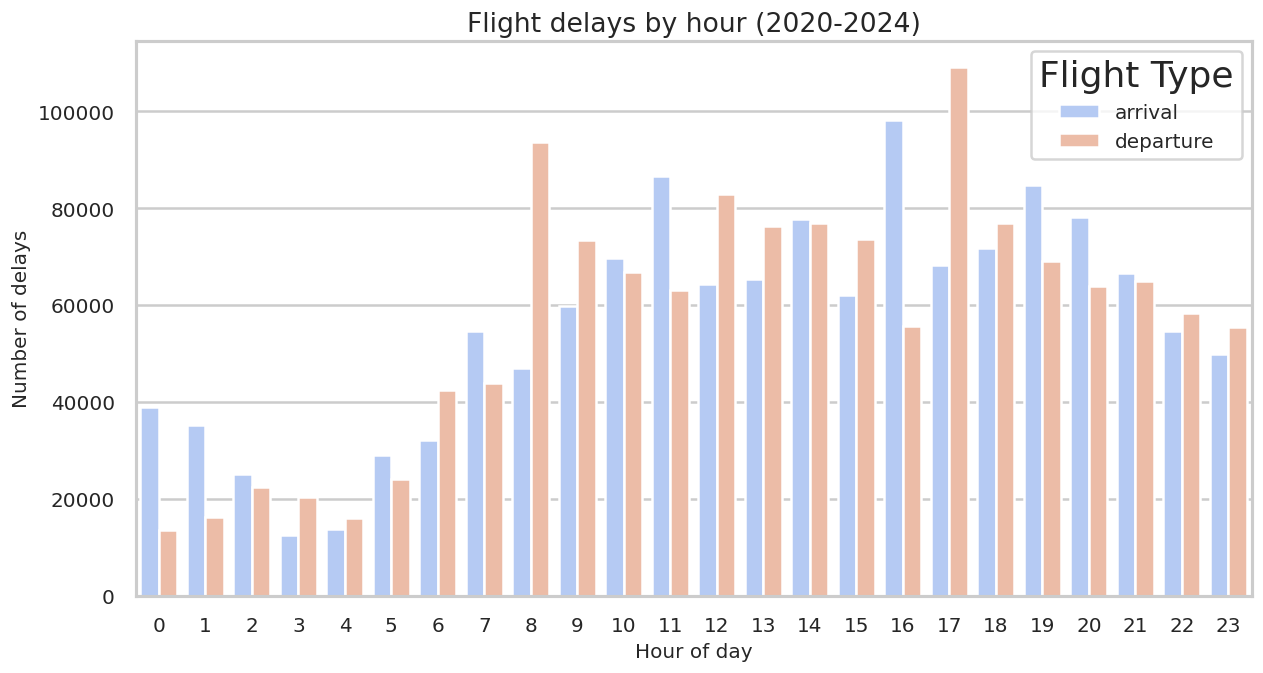

In [13]:
# === 1️⃣ Seaborn Styling for Consistency ===
sns.set_theme(
    context="talk",
    style="whitegrid",
    palette="Blues",
    font="sans-serif",
    font_scale=1.2
)

plt.rcParams.update({
    'figure.figsize': (10, 6),
    'figure.dpi': 120,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})
sns.despine()

# === 2️⃣ Connect to DuckDB & Fetch Data for 5-Year Periods ===
conn = duckdb.connect("flight_monolith.duckdb")

query = """
WITH delayed_partida AS (
    SELECT
        CASE 
            WHEN ano BETWEEN 2000 AND 2004 THEN '2000-2004'
            WHEN ano BETWEEN 2005 AND 2009 THEN '2005-2009'
            WHEN ano BETWEEN 2010 AND 2014 THEN '2010-2014'
            WHEN ano BETWEEN 2015 AND 2019 THEN '2015-2019'
            WHEN ano BETWEEN 2020 AND 2024 THEN '2020-2024'
        END AS time_period,
        'departure' AS flight_type,
        EXTRACT(hour FROM hora_partida_prevista) AS hour
    FROM flights
    WHERE status_partida = 'atrasado' AND ano < 2025
),
delayed_chegada AS (
    SELECT
        CASE 
            WHEN ano BETWEEN 2000 AND 2004 THEN '2000-2004'
            WHEN ano BETWEEN 2005 AND 2009 THEN '2005-2009'
            WHEN ano BETWEEN 2010 AND 2014 THEN '2010-2014'
            WHEN ano BETWEEN 2015 AND 2019 THEN '2015-2019'
            WHEN ano BETWEEN 2020 AND 2024 THEN '2020-2024'
        END AS time_period,
        'arrival' AS flight_type,
        EXTRACT(hour FROM hora_chegada_prevista) AS hour
    FROM flights
    WHERE status_chegada = 'atrasado' AND ano < 2025
)
SELECT
    time_period,
    flight_type,
    hour,
    COUNT(*) AS num_delays
FROM (
    SELECT * FROM delayed_partida
    UNION ALL
    SELECT * FROM delayed_chegada
)
GROUP BY time_period, flight_type, hour
ORDER BY time_period, flight_type, hour
"""

df_delays = conn.execute(query).fetchdf()

# === 3️⃣ Plot Delays by 5-Year Periods ===
time_periods = df_delays["time_period"].unique()

for period in time_periods:
    df_period = df_delays[df_delays["time_period"] == period]

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=df_period,
        x="hour",
        y="num_delays",
        hue="flight_type",
        palette="coolwarm"
    )

    plt.title(f"Flight delays by hour ({period})", fontsize=16)
    plt.xlabel("Hour of day", fontsize=12)
    plt.ylabel("Number of delays", fontsize=12)
    plt.xticks(range(0, 24))  # Ensure all hours are displayed
    plt.legend(title="Flight Type", loc="upper right")
    
    plt.show()


# Overview

This function examines seasonal flight patterns by month for multiple years (2015–2024). It retrieves flight counts from the DuckDB database, grouped by both year and month, and displays the data as a line chart. Each line represents a different year, allowing quick visual comparisons of month-to-month trends across multiple years.

---

## Analysis

1. **Seasonal patterns**  
   - Each line generally shows similar seasonal fluctuation: busier months (e.g., summer or holiday periods) vs. slower months (e.g., early winter).  
   - By plotting multiple years together, one can see whether these seasonal peaks and troughs remain consistent or shift over time.

2. **Year-to-year differences**  
   - Some years may show higher overall volumes across all months, indicating growth in flight operations.  
   - Sudden dips or spikes in certain months can point to external events (e.g., covid).

3. **Month-by-Month Insight**  
   - The x-axis labels (Jan–Dec) make it straightforward to identify precisely which months see the greatest fluctuations. This helps in forecasting and operational planning.

---

## Conclusion

By plotting flight counts for multiple years on a single chart, this function provides a clear view of how seasonal factors influence flight volume over time. Analysts can quickly spot recurring patterns, unusual deviations, and long-term shifts in seasonality—critical insights for capacity planning, revenue management, and strategic decision-making in the aviation industry.

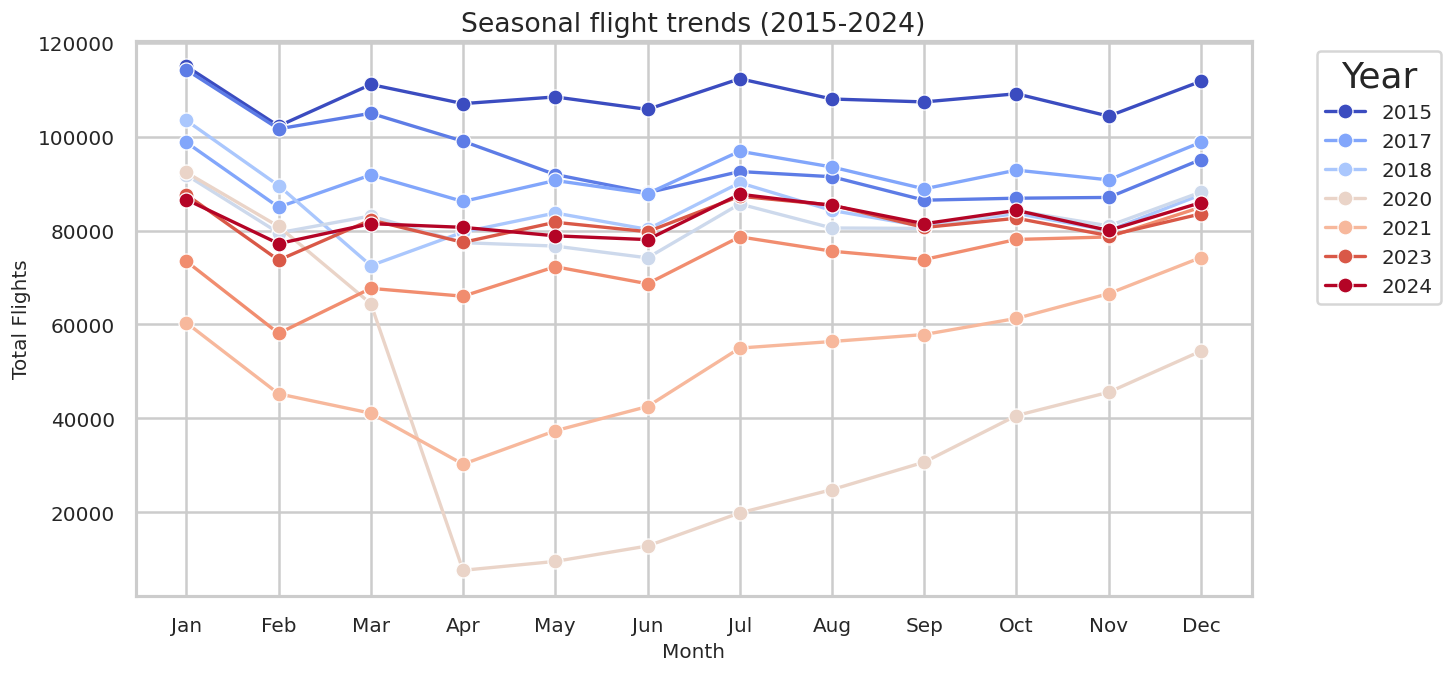

In [14]:
def plot_seasonality_multiple_years(start_year=2015, end_year=2024):
    """Plots flight trends across months for multiple years in one figure."""
    
    # Fetch data for all years at once
    query = f"""
        SELECT ano AS year, mes AS month, COUNT(*) AS total_flights
        FROM flights
        WHERE ano BETWEEN {start_year} AND {end_year}
        GROUP BY ano, mes
        ORDER BY ano, mes;
    """
    df_seasonal = conn.execute(query).fetchdf()

    # Convert month to categorical for proper sorting
    df_seasonal["month"] = pd.Categorical(df_seasonal["month"], categories=range(1, 13), ordered=True)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_seasonal, x="month", y="total_flights", hue="year", marker="o", linewidth=2, palette="coolwarm")

    # Styling
    plt.title(f"Seasonal flight trends ({start_year}-{end_year})", fontsize=16)
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("Total Flights", fontsize=12)
    plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
    plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show plot
    plt.show()

# Call function for 2015-2024
plot_seasonality_multiple_years(2015, 2024)

# Overview

This workflow constructs a directed flight network from a DuckDB table of routes, then applies graph-theoretic measures (degree, betweenness, and closeness centrality) to identify the most influential airports. It culminates in a subgraph visualization of key airports, illustrating how they connect within the broader network.

---

## Steps in the code

1. **Plot style setup**  
   - Configures Seaborn and Matplotlib to produce consistent, presentation-ready figures (white grid, larger fonts, and higher DPI).

2. **Database connection & route aggregation**  
   - Connects to the DuckDB database (`flight_monolith.duckdb`).  
   - Executes a query to group flights by origin-destination pairs, computing both the total number of flights (`num_flights`) and the average delay in minutes (`avg_delay_minutes`).

3. **Graph construction**  
   - Builds a directed graph (`DiGraph`) from the aggregated route data using NetworkX.  
   - Each airport is a node, and each route is a directed edge from the origin to the destination.  
   - Edge attributes store the total flights (`num_flights`) and average delay (`avg_delay_minutes`).

4. **Centrality computation**  
   - **Degree Centrality** (`nx.degree_centrality`): Measures the proportion of all possible connections each node has (both in and out).  
   - **In-Degree / Out-Degree Centrality** (`nx.in_degree_centrality` / `nx.out_degree_centrality`): Focus on how many connections flow into or out of each airport, respectively.  
   - **Betweenness Centrality** (`nx.betweenness_centrality`): Indicates how often a node lies on the shortest path between other nodes, highlighting airports that act as critical intermediaries.  
   - **Closeness Centrality** (`nx.closeness_centrality`): Reflects how close an airport is to all others in terms of path distance, capturing how quickly it can reach (or be reached from) other nodes.

5. **DataFrame of centralities**  
   - Converts the centrality dictionaries into a single Pandas DataFrame, making it straightforward to rank airports by each metric.

6. **Top airports by centrality**  
   - Prints the top 10 airports based on degree, betweenness, and closeness centralities.  
   - For example, SBGR (Guarulhos Airport) appears highly in all measures, indicating it is a major hub with many connections and strong strategic importance in the network.
   - 
---

## Analysis

- **Degree centrality:**  
  - SBGR, SBKP, and SBGL lead, showing they connect to a large portion of the network, both incoming and outgoing.  
  - These airports handle a broad spread of routes, making them highly influential in overall connectivity.

- **Betweenness centrality:**  
  - SBGR again dominates, with SBEG and SBKP also ranking high. Airports with high betweenness often serve as critical transit points, meaning flights between otherwise distant airports frequently pass through them.

- **Closeness centrality:**  
  - SBGR remains on top, followed by SBKP, SBGL, SBCF, and SBBR. Airports with high closeness can reach other airports with relatively few hops, facilitating efficient travel across the network.

- **Subgraph insights:**  
  - Visualizing only the top airports in the subgraph highlights their dense interconnections.  
  - This smaller network reveals how major hubs form a backbone of the flight system, while peripheral airports may appear with fewer direct connections or depend on these hubs to link to the rest of the network.

Overall, the centrality measures confirm that a handful of major airports function as the network’s key hubs, influencing both connectivity and operational efficiency. This information can guide decisions on route planning, infrastructure investment, and delay mitigation strategies. 

Top 10 Airports by Degree Centrality:
    airport  degree_centrality  in_degree_centrality  out_degree_centrality  \
5     SBGR           0.576194              0.278241               0.297953   
34    SBKP           0.463230              0.234268               0.228961   
59    SBGL           0.410159              0.203942               0.206217   
53    SBEG           0.336619              0.162244               0.174375   
54    SBCF           0.319939              0.165277               0.154663   
2     SBBR           0.317665              0.157695               0.159970   
51    SBSV           0.293404              0.144807               0.148597   
7     SBRF           0.247157              0.124337               0.122820   
12    SBSP           0.242608              0.122820               0.119788   
6     SBCT           0.232752              0.121304               0.111448   

    betweenness_centrality  closeness_centrality  
5                 0.163543              0.509989  


<Figure size 1000x600 with 0 Axes>

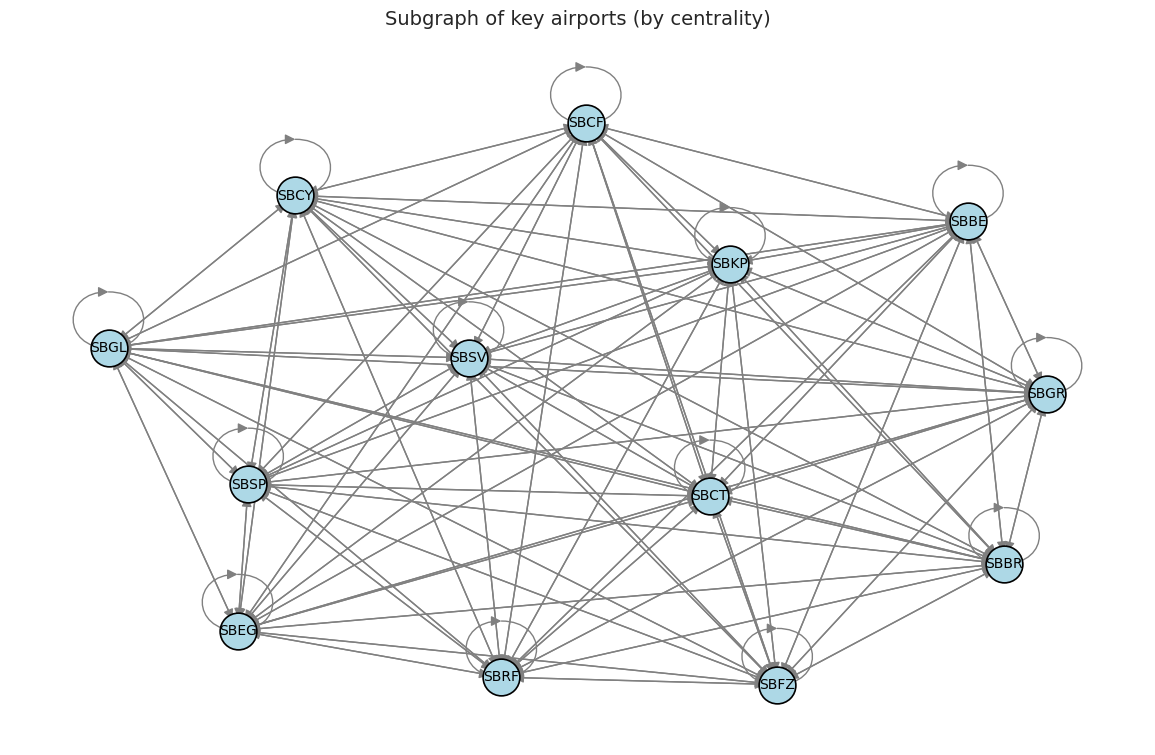

In [15]:
# 1. Set up the plotting style (similar to before)
sns.set_theme(
    context="talk",       # larger fonts for presentations
    style="whitegrid",    # clean grid background
    palette="Blues",      # all default plots in shades of blue
    font="sans-serif",
    font_scale=1.2
)
plt.rcParams['figure.figsize'] = (10, 6)   # default figure size
plt.rcParams['figure.dpi'] = 100           # higher DPI for sharper visuals
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
sns.despine()  # remove top/right spines for a modern look

# 2. Connect to DuckDB and get aggregated data for each (origin -> destination)
con = duckdb.connect("flight_monolith.duckdb")

query = """
SELECT
    aeroporto_origem AS origin,
    aeroporto_destino AS destination,
    COUNT(*) AS num_flights,
    AVG(
        EXTRACT(
            EPOCH FROM (
                (dia_partida_real + hora_partida_real)
                - (dia_partida_prevista + hora_partida_prevista)
            )
        ) / 60.0
    ) AS avg_delay_minutes
FROM flights
GROUP BY origin, destination
"""

df_routes = con.execute(query).df()

# 3. Build a directed graph from the route data
#    - source = origin, target = destination
#    - edge_attr can store 'num_flights' and 'avg_delay_minutes'
G = nx.from_pandas_edgelist(
    df_routes,
    source='origin',
    target='destination',
    edge_attr=['num_flights', 'avg_delay_minutes'],
    create_using=nx.DiGraph()
)

# 4. Compute centrality measures
deg_centrality = nx.degree_centrality(G)         # Overall (in + out)
in_deg_centrality = nx.in_degree_centrality(G)   # Focus on incoming edges
out_deg_centrality = nx.out_degree_centrality(G) # Focus on outgoing edges
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# 5. Convert centralities into a DataFrame for analysis
metrics_df = pd.DataFrame({
    'airport': list(deg_centrality.keys()),
    'degree_centrality': list(deg_centrality.values()),
    'in_degree_centrality': list(in_deg_centrality.values()),
    'out_degree_centrality': list(out_deg_centrality.values()),
    'betweenness_centrality': list(betweenness_centrality.values()),
    'closeness_centrality': list(closeness_centrality.values())
})

# 6. Identify top airports by different centralities
top_degree = metrics_df.nlargest(10, 'degree_centrality')
top_betweenness = metrics_df.nlargest(10, 'betweenness_centrality')
top_closeness = metrics_df.nlargest(10, 'closeness_centrality')

print("Top 10 Airports by Degree Centrality:\n", top_degree)
print("Top 10 Airports by Betweenness Centrality:\n", top_betweenness)
print("Top 10 Airports by Closeness Centrality:\n", top_closeness)

# 7. (Optional) Visualize a subgraph if you have too many airports
#    For example, only keep airports with at least X flights or in top centralities
important_airports = set(top_degree['airport']) | set(top_betweenness['airport']) | set(top_closeness['airport'])
subgraph = G.subgraph(important_airports)

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Use the same seaborn theme settings as before for consistency
sns.set_theme(
    context="talk",
    style="whitegrid",
    palette="Blues",
    font="sans-serif",
    font_scale=1.2
)

# Suppose we already have our subgraph (named `subgraph`) from earlier steps
# For example:
# subgraph = G.subgraph(important_airports)

# 1. Generate a layout for the subgraph (spring_layout is a common choice)
pos = nx.spring_layout(subgraph, k=0.7, seed=42)

# 2. Create a larger figure
plt.figure(figsize=(12, 8))

# 3. Draw edges first (use a subtle gray color, bigger arrowheads)
nx.draw_networkx_edges(
    subgraph,
    pos,
    edge_color="gray",
    arrowsize=15,
    arrowstyle="-|>",  # for a nice arrow shape
    width=1.0
)

# 4. Draw nodes (larger, with black edges around them)
nx.draw_networkx_nodes(
    subgraph,
    pos,
    node_size=700,
    node_color="lightblue",
    edgecolors="black",  # outline color for the nodes
    linewidths=1.2
)

# 5. Draw labels (slightly smaller font, black color)
nx.draw_networkx_labels(
    subgraph,
    pos,
    font_size=10,
    font_color="black"
)

# 6. Add a title and remove axis borders
plt.title("Subgraph of key airports (by centrality)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

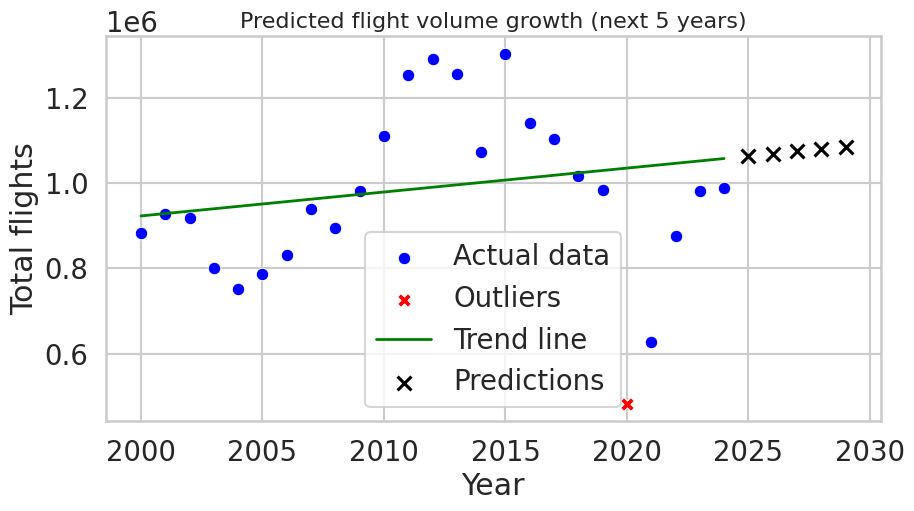

In [16]:
# Connect to DuckDB
conn = duckdb.connect("flight_monolith.duckdb")

def detect_outliers_iqr(data):
    """Detects outliers using the IQR method."""
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

def predict_flight_growth():
    """Predicts future flight volumes using linear regression after removing outliers."""
    
    # Fetch flight data
    query = """
        SELECT ano AS year, COUNT(*) AS total_flights
        FROM flights
        WHERE ano < 2025
        GROUP BY ano
        ORDER BY ano;
    """
    df_trend = conn.execute(query).fetchdf()

    # Detect outliers using IQR
    outlier_mask = detect_outliers_iqr(df_trend["total_flights"])
    df_filtered = df_trend[~outlier_mask]  # Keep only non-outliers
    df_outliers = df_trend[outlier_mask]   # Separate outliers for visualization

    # Prepare training data
    X = df_filtered["year"].values.reshape(-1, 1)
    y = df_filtered["total_flights"].values

    # Train regression model
    model = LinearRegression()
    model.fit(X, y)

    # Predict next 5 years
    future_years = np.array(range(df_filtered["year"].max() + 1, df_filtered["year"].max() + 6)).reshape(-1, 1)
    future_predictions = model.predict(future_years)

    # Plot results
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=df_filtered, x="year", y="total_flights", label="Actual data", color="blue")
    sns.scatterplot(data=df_outliers, x="year", y="total_flights", label="Outliers", color="red", marker="X", s=100)
    plt.plot(df_filtered["year"], model.predict(X), color="green", label="Trend line", linewidth=2)
    plt.scatter(future_years, future_predictions, color="black", label="Predictions", marker="x", s=100)

    plt.title("Predicted flight volume growth (next 5 years)", fontsize=16)
    plt.xlabel("Year")
    plt.ylabel("Total flights")
    plt.legend()
    plt.show()

predict_flight_growth()

# Overview

This code retrieves historical flight data from a DuckDB database, removes outliers using the IQR method, and fits a linear regression model to predict flight volumes for the next five years. The result is a chart that includes:
- Historical data (with outliers highlighted),
- A trend line derived from the filtered data,
- Future predictions for the subsequent five years.

---

## Steps in the code

1. **Seaborn styling**  
   - Configures Seaborn and Matplotlib to produce presentation-quality visuals, setting a white grid background, larger fonts, and consistent color palettes.

2. **Database connection**  
   - Connects to `flight_monolith.duckdb`, which contains the `flights` table.  
   - The query retrieves `year` and total flights per year (excluding 2025 and beyond).

3. **Outlier detection (IQR Method)**  
   - Calculates the 25th (Q1) and 75th (Q3) percentiles of total flights.  
   - Computes the interquartile range (IQR = Q3 – Q1).  
   - Defines outliers as points lying below `(Q1 – 1.5 * IQR)` or above `(Q3 + 1.5 * IQR)`.  
   - Splits the dataset into two parts: filtered (non-outliers) and outliers.

4. **Linear regression**  
   - Uses the filtered dataset to train a `LinearRegression` model, treating `year` as the independent variable and `total_flights` as the dependent variable.  
   - Fits the model on the non-outlier data, reducing skew from extreme values.

5. **Future predictions**  
   - Generates an array of future years (the next five years after the max year in the filtered data).  
   - Applies the trained model to predict flight volumes for these future years.

6. **Plotting**  
   - **Historical Data (Filtered):** Plotted as blue scatter points (`"Actual Data"`).  
   - **Outliers:** Plotted in red (`"Outliers"`) for clarity.  
   - **Trend Line:** A dark blue line (`"Trend Line"`) fitted through the filtered data.  
   - **Predictions:** Shown as black `"X"` markers and connected by a dashed line to illustrate the forecasted growth trend.

7. **Labels & legend**  
   - Adds a title, axis labels, and a legend for clarity.  
   - Distinguishes between actual data, outliers, trend line, and future predictions.

---

## Observations

1. **Outlier influence:**  
   - By removing outliers, the regression line more accurately reflects typical flight volume trends.  
   - Outliers are still shown on the chart, highlighting anomalous years.

2. **Linear trend:**  
   - The linear regression suggests a gradual upward trajectory in flight volumes.  
   - The slope of the line indicates the average year-over-year growth based on historical (filtered) data.

3. **Future outlook:**  
   - Predicted volumes for the next five years appear as black markers with a dashed connecting line.  
   - The forecast assumes continued linear growth, ignoring potential external shocks or changes in flight behavior.

---

## Conclusion

This script demonstrates a straightforward approach to forecasting flight volumes:  
- **Data cleansing:** Mitigating outlier impact via the IQR method.  
- **Simple modeling:** Employing a linear regression for its interpretability.  
- **Visualization:** Displaying both historical trends and a short-term outlook in a single, clear plot.

Such a model provides a baseline expectation for flight growth. However, for more robust or long-term forecasting, additional factors (economic indicators, global events, etc.) may need to be considered.


<Figure size 1200x720 with 0 Axes>

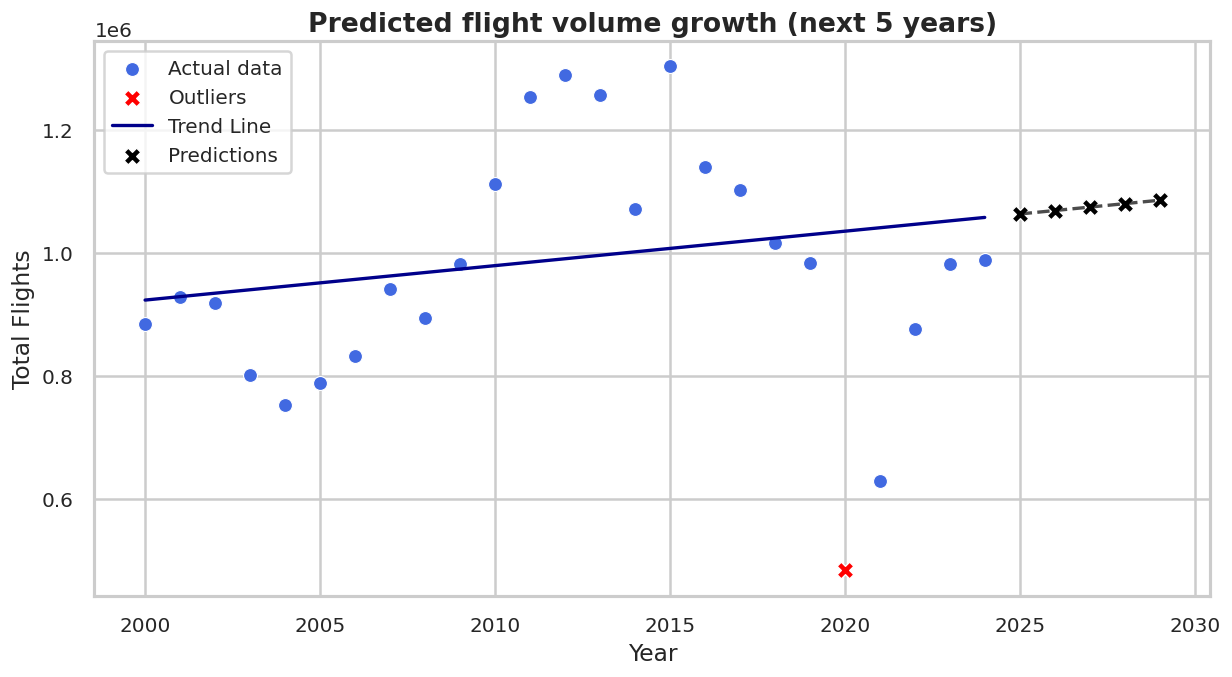

In [22]:
# === 1️⃣ Seaborn Styling for High-End Visualization ===
sns.set_theme(
    context="talk",
    style="whitegrid",
    palette="Blues",
    font="sans-serif",
    font_scale=1.2
)

plt.rcParams.update({
    'figure.figsize': (10, 6),
    'figure.dpi': 120,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})
sns.despine()

# === 2️⃣ Connect to DuckDB ===
conn = duckdb.connect("flight_monolith.duckdb")

def detect_outliers_iqr(data):
    """Detects outliers using the IQR method."""
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

def predict_flight_growth():
    """Predicts future flight volumes using linear regression after removing outliers."""

    # === 3️⃣ Fetch Flight Data ===
    query = """
        SELECT ano AS year, COUNT(*) AS total_flights
        FROM flights
        WHERE ano < 2025
        GROUP BY ano
        ORDER BY ano;
    """
    df_trend = conn.execute(query).fetchdf()

    # === 4️⃣ Detect Outliers using IQR ===
    outlier_mask = detect_outliers_iqr(df_trend["total_flights"])
    df_filtered = df_trend[~outlier_mask]  # Keep only non-outliers
    df_outliers = df_trend[outlier_mask]   # Separate outliers for visualization

    # === 5️⃣ Prepare Training Data ===
    X = df_filtered["year"].values.reshape(-1, 1)
    y = df_filtered["total_flights"].values

    # Train regression model
    model = LinearRegression()
    model.fit(X, y)

    # Predict next 5 years
    future_years = np.array(range(df_filtered["year"].max() + 1, df_filtered["year"].max() + 6)).reshape(-1, 1)
    future_predictions = model.predict(future_years)

    # === 6️⃣ Plot the Improved Visualization ===
    plt.figure(figsize=(12, 6))
    
    # Scatter actual data
    sns.scatterplot(data=df_filtered, x="year", y="total_flights", color="royalblue", label="Actual data", s=70)

    # Scatter outliers
    sns.scatterplot(data=df_outliers, x="year", y="total_flights", color="red", marker="X", label="Outliers", s=100)

    # Trend line
    sns.lineplot(x=df_filtered["year"], y=model.predict(X), color="darkblue", label="Trend Line", linewidth=2)

    # Future predictions
    sns.scatterplot(x=future_years.flatten(), y=future_predictions, color="black", marker="X", s=100, label="Predictions")
    
    # Dashed projection line for future predictions
    plt.plot(future_years, future_predictions, linestyle="dashed", color="black", alpha=0.7, linewidth=2)

    # === 7️⃣ Titles & Labels ===
    plt.title("Predicted flight volume growth (next 5 years)", fontsize=16, fontweight="bold")
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Total Flights", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(frameon=True, loc="upper left")

    plt.show()

predict_flight_growth()


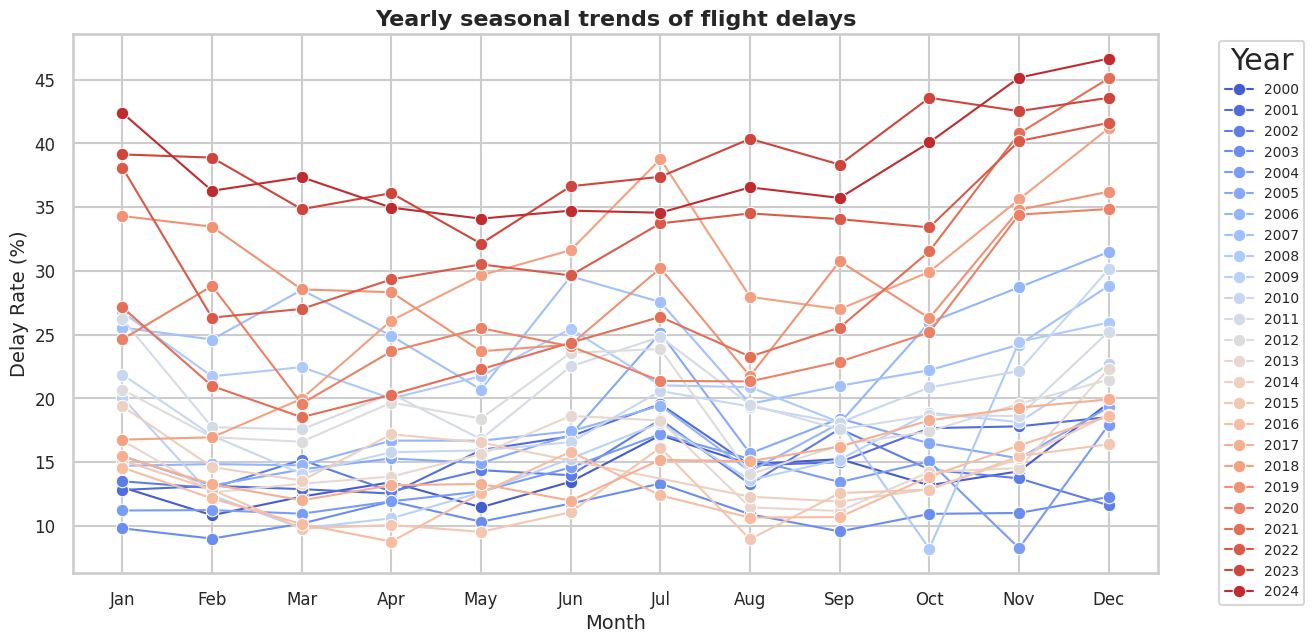

In [18]:
# Connect to DuckDB
conn = duckdb.connect("flight_monolith.duckdb")

# Query: Aggregate delay rates per year-month
query = """
    SELECT ano AS Year, mes AS Month, 
           COUNT(*) AS Total_Flights,
           SUM(CASE WHEN status_partida = 'atrasado' THEN 1 ELSE 0 END) * 100.0 / NULLIF(COUNT(*), 0) AS Delay_Rate
    FROM flights
    WHERE ano BETWEEN 2000 AND 2024  -- Focus on complete years
          AND status_partida IS NOT NULL  -- Ensure valid cases
    GROUP BY ano, mes
    ORDER BY ano, mes;
"""

# Fetch results
df_seasonal = conn.execute(query).fetchdf()

# Convert month to integer (ensuring sorting order)
df_seasonal['Month'] = df_seasonal['Month'].astype(int)

# Convert year to string for categorical plotting
df_seasonal['Year'] = df_seasonal['Year'].astype(str)

# Set plot style
sns.set_theme(
    context="talk",
    style="whitegrid",
    palette="Blues",
    font="sans-serif",
    font_scale=1.2
)

plt.figure(figsize=(14, 7))
sns.lineplot(data=df_seasonal, x="Month", y="Delay_Rate", hue="Year", palette="coolwarm", marker="o", linewidth=1.5)

# Style adjustments
plt.title("Yearly seasonal trends of flight delays", fontsize=16, fontweight="bold")
plt.xlabel("Month", fontsize=14)
plt.ylabel("Delay Rate (%)", fontsize=14)
plt.xticks(range(1, 13), labels=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun", 
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
], fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Show plot
plt.show()


# Overview

This script computes and visualizes flight delay rates by hour of the day, grouped into five-year intervals. By comparing how delays vary at different times (0–23 hours) across these time spans (2000–2004, 2005–2009, etc.), the plot highlights temporal changes in delay patterns over the course of more than two decades.

---

## Steps in the code

1. **Database connection**  
   - Establishes a connection to the DuckDB database (`conn = duckdb.connect(db_path)`), which stores the flight records.

2. **Data query**  
   - Executes a SQL query that:
     - Categorizes years into five-year periods (e.g., `2000-2004`, `2005-2009`, etc.).  
     - Extracts the hour of the scheduled departure time (`hora_partida_prevista`) as `departure_hour`.  
     - Calculates the total number of flights (`COUNT(*)`) and the percentage of flights delayed (`delay_rate`) within each hour block for each five-year period.  
   - Filters out any rows where the departure status is null to ensure only valid data is analyzed.

3. **Data grouping and pivoting**  
   - Groups the result by `departure_hour` and `five_year_period`, then averages the `delay_rate`.  
   - Uses a pivot table to transform rows into columns based on the five-year period. This structure allows easy plotting of multiple lines (one for each period) against the departure hour.

4. **Plot configuration**  
   - Sets a Seaborn theme (`whitegrid`) and uses a larger font scale for clarity.  
   - Creates a 12×6 inch figure for the line plot.

5. **Plotting**  
   - Iterates over each five-year period in the pivoted DataFrame, plotting the delay rate (y-axis) by departure hour (x-axis).  
   - Each period is shown with markers and lines, labeled in the legend for easy distinction.

6. **Style adjustments**  
   - Adds a title indicating the comparison of flight delay rates by hour for five-year groupings.  
   - Labels the x-axis as “Hour of day” and y-axis as “Delay rate (%)”.  
   - Places the legend in the upper right, labeling each line by its respective time span.

7. **Visualization**  
   - The final plot shows how delays vary by hour, comparing patterns across different five-year windows from 2000 to 2024.

---

## Analysis of the Plot

- **Hourly delay patterns**  
  Each line illustrates the percentage of flights delayed at each hour. Typically, delays may be lower in early morning hours and rise throughout the day due to cumulative operational factors or peak traffic times.

- **Comparisons across Time Periods**  
  By grouping the data into five-year intervals, the plot reveals whether certain hours of the day have become more or less prone to delays over time. For instance, a spike in midday delays during the 2010–2014 period might indicate changes in airline scheduling or airport congestion.

- **Operational and Seasonal Factors**  
  While the chart focuses on hour of day, real-world delays can also be influenced by seasonal demand, weather, or broader industry shifts. Viewing multiple five-year periods side by side can hint at the long-term evolution of these influences.

- **Actionable Insights**  
  - **Resource Allocation:** Airports and airlines can adjust staffing or gate availability during the hours that consistently show higher delays.  
  - **Schedule Optimization:** Airlines might reschedule flights away from peak-delay windows, if feasible.  
  - **Further Investigation:** Sharp changes in delay rates between periods can prompt deeper analysis into what triggered those shifts (policy changes, technology adoption, external disruptions, etc.).

---

## Conclusion

By breaking down delay rates by hour of day and grouping data into five-year intervals, this script offers a clear historical perspective on how flight delays have evolved over time. The resulting chart makes it easier to pinpoint periods and hours that need attention for operational improvements, ultimately guiding strategies to reduce delays and enhance overall flight reliability.


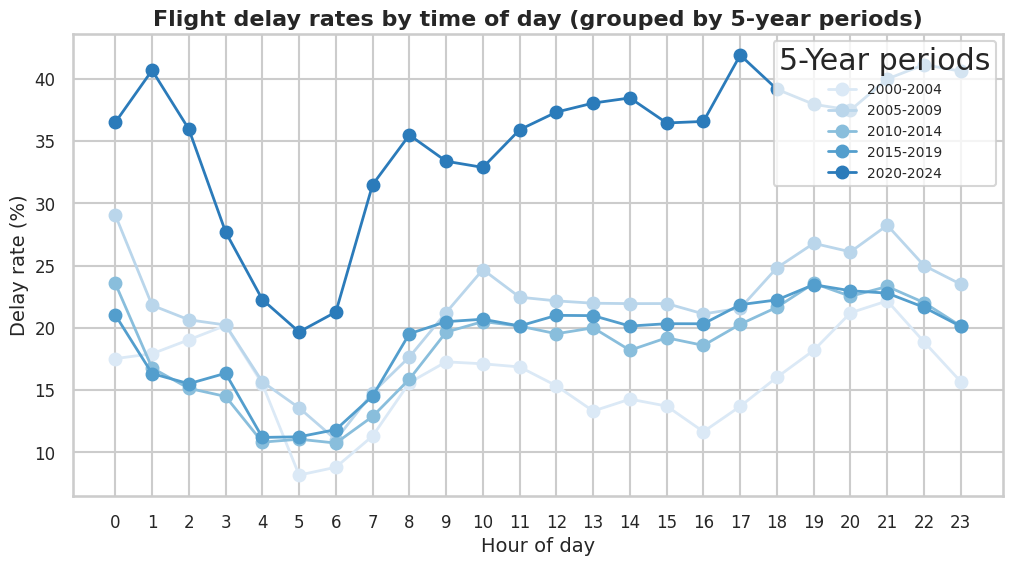

In [19]:
# Connect to DuckDB
conn = duckdb.connect(db_path)

# Query: Delay rates by time of day grouped into 5-year periods
query = """
SELECT 
    CASE 
        WHEN ano BETWEEN 2000 AND 2004 THEN '2000-2004'
        WHEN ano BETWEEN 2005 AND 2009 THEN '2005-2009'
        WHEN ano BETWEEN 2010 AND 2014 THEN '2010-2014'
        WHEN ano BETWEEN 2015 AND 2019 THEN '2015-2019'
        WHEN ano BETWEEN 2020 AND 2024 THEN '2020-2024'
    END AS five_year_period,
    CAST(SUBSTRING(CAST(hora_partida_prevista AS VARCHAR), 1, 2) AS INTEGER) AS departure_hour,
    COUNT(*) AS total_flights,
    SUM(CASE WHEN status_partida = 'atrasado' THEN 1 ELSE 0 END) * 100.0 / NULLIF(COUNT(*), 0) AS delay_rate
FROM flights
WHERE status_partida IS NOT NULL  
GROUP BY five_year_period, departure_hour
ORDER BY five_year_period, departure_hour;
"""

# Fetch results into a DataFrame
df = conn.execute(query).fetchdf()

# Ensure unique values before pivoting
df_grouped = df.groupby(['departure_hour', 'five_year_period'], as_index=False)['delay_rate'].mean()

# Pivot the data safely
df_pivot = df_grouped.pivot(index='departure_hour', columns='five_year_period', values='delay_rate')

# Set plot style
sns.set_theme(
    context="talk",
    style="whitegrid",
    palette="Blues",
    font="sans-serif",
    font_scale=1.2
)

# Create the plot
plt.figure(figsize=(12, 6))

for period in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[period], marker='o', linestyle='-', label=period, linewidth=2)

# Style Adjustments
plt.title("Flight delay rates by time of day (grouped by 5-year periods)", fontsize=16, fontweight="bold")
plt.xlabel("Hour of day", fontsize=14)
plt.ylabel("Delay rate (%)", fontsize=14)
plt.xticks(range(0, 24), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="5-Year periods", loc="upper right", fontsize=10, frameon=True)

# Show the plot
plt.show()
